## Bernie vs Trump

This is a toy example on how to fine-tune on a classification problem.

We have collected sentences from two US presidential candidates and our task is to know from which person they come from.

In [19]:
from typing import Tuple

import seaborn as sns
import numpy as np
import pandas as pd

from ignite.engine import (
    Events,
    Engine,
)
from ignite.metrics import Accuracy

import torch
from torch.utils.data import (
    DataLoader,
    TensorDataset
)

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
)

from scipy.special import softmax

from sklearn.model_selection import train_test_split

from data import load_data

from tqdm import tqdm
tqdm.pandas()

pd.set_option('display.max_colwidth', None)

/home/dani/anaconda3/envs/bert/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Read and visualize data

In [20]:
sentences = load_data('data', balance=True)
sentences.sample(5)

,sentence,is_trump
315,"I have never seen — it looked like the Academy Awards, the press. We have a lot of press here today. They’re all live — look at all those live cameras.",True
210,"First of all, Univision is being sued like crazy; you wouldn’t believe it.",True
63,"Everyone says Trump won the debate. Everybody. And hat is it. So, the ad is him asking the question and I’m standing there like this, because I haven’t — in fact, you see in one of them, I’m just about ready to open my mouth.",True
38,"In a famous 1936 campaign speech Roosevelt stated, “We had to struggle with the old enemies of peace–business and financial monopoly, speculation, reckless banking, class antagonism, sectionalism, war profiteering.",False
118,And let me be absolutely clear: democratic socialism to me requires achieving political and economic freedom in every community.,False


## Load tokenizer 

In [21]:
pretrained_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

## Decide token length

In [22]:
trump_token_ids = sentences[sentences.is_trump].sentence.apply(
    lambda x: tokenizer.encode(str(x), add_special_tokens=False)
)

bernie_token_ids = sentences[~sentences.is_trump].sentence.apply(
    lambda x: tokenizer.encode(str(x), add_special_tokens=False)
)

Let's visualize the token length per class.

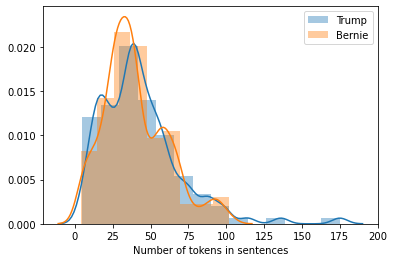

In [23]:
ax = sns.distplot(
    list(map(len, trump_token_ids)),
         hist=True,
         kde=True,
         norm_hist=True,
         kde_kws={'bw': 5},
         label='Trump',
         axlabel='Number of tokens in sentences',
)

sns.distplot(
    list(map(len, bernie_token_ids)),
         hist=True,
         kde=True,
         norm_hist=True,
         ax=ax,
         label='Bernie',
         kde_kws={'bw': 5},
)

ax.legend()

In [24]:
max_token_num = 70

I am going to limit the length of the sentences to 70.

Let's split data between training and validation.

In [25]:
train_sentences, val_sentences = train_test_split(sentences, test_size=0.18)
print(f'Sentences in training: {len(train_sentences)}')
print(f'Sentences in validation: {len(val_sentences)}')

Sentences in training: 201
Sentences in validation: 45


## Load pre-trained classification model

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False).to(device)

- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Note warning tells us exactly what we expect to happen before fine-tuning.

## Create data loaders

Let's compute the needed set of arrays to input to BERT.

In [27]:
def encode_sentence(text: str, max_length: int) -> Tuple[np.ndarray, np.ndarray]:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        pad_to_max_length=True,
        return_attention_mask = True
    )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']


def process_data(df: pd.DataFrame,
                 max_length: int) -> Tuple[np.ndarray,
                                           np.ndarray,
                                           np.ndarray]:
    """ Map sentences in DataFrame into proper model inputs
    
    We are extracting, for each sentence:
    
        - List of token identifiers (including special tokens)
        - Input attention masks (which prevent focusing on padding tokens)
        - Sentence label
        
    Number of tokens are padded to the maximum provided (special
    tokens are considered for computing the length of the sentence).
    
    """
    encoded_dicts = df.sentence.apply(
        lambda x: encode_sentence(x, max_length=max_length)
    )
    token_ids, attention_masks = zip(*encoded_dicts)
    return token_ids, attention_masks, df.is_trump.values


def build_dataset(df: pd.DataFrame,
                  max_length: int) -> torch.utils.data.Dataset:
    token_ids, attention_masks, labels = process_data(df,
                                                      max_length=max_length)
    return TensorDataset(torch.Tensor(token_ids).to(torch.long),
                         torch.Tensor(attention_masks),
                         torch.Tensor(labels).to(torch.long))

# As dataset is small, we can fit it on memory
train_dataset = build_dataset(train_sentences, max_length=max_token_num)
val_dataset = build_dataset(val_sentences, max_length=max_token_num)

Create dataset loaders.

In [28]:
batch_size = 32

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

## Set training loop

Initialize optimizer.

In [29]:
optimizer = AdamW(model.parameters(), lr = 1e-5)  # integrated LR decay

Define train step.

In [30]:
def train_step(engine, batch):

    model.train()
    
    optimizer.zero_grad()
    
    batch_token_ids = batch[0].to(device)
    batch_att_masks = batch[1].to(device)
    batch_labels = batch[2].to(device)
    
    loss, _ = model(batch_token_ids,
                    attention_mask=batch_att_masks, 
                    labels=batch_labels)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

Define validation step.

In [31]:
def validation_step(engine, batch):
    
    model.eval()
    
    with torch.no_grad():
        
        batch_token_ids = batch[0].to(device)
        batch_att_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)

        batch_logits = model(batch_token_ids, attention_mask=batch_att_masks)
        return batch_logits[0], batch_labels

Create trainer and evaluator engines.

In [32]:
trainer = Engine(train_step)

evaluator = Engine(validation_step)
accuracy = Accuracy()
accuracy.attach(evaluator, 'accuracy')

Define callbacks.

In [33]:
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(trainer):
    iteration = trainer.state.iteration
    n_iterations = trainer.state.epoch_length
    print(
        f'Epoch[{trainer.state.epoch}/{trainer.state.max_epochs}] '
        f'Iteration[{(iteration - 1) % n_iterations}/{n_iterations}] '
        f'Loss: {trainer.state.output:.2f}'
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print(f'Training Results - Epoch: {trainer.state.epoch}, '
          f'Accuracy: {metrics["accuracy"]:.2f}')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f'Validation Results - Epoch: {trainer.state.epoch}, '
          f'Accuracy: {metrics["accuracy"]:.2f}')

In [34]:
trainer.run(train_loader, max_epochs=3);

Epoch[1/3] Iteration[0/7] Loss: 0.72
Epoch[1/3] Iteration[1/7] Loss: 0.71
Epoch[1/3] Iteration[2/7] Loss: 0.70
Epoch[1/3] Iteration[3/7] Loss: 0.67
Epoch[1/3] Iteration[4/7] Loss: 0.67
Epoch[1/3] Iteration[5/7] Loss: 0.63
Epoch[1/3] Iteration[6/7] Loss: 0.62
Training Results - Epoch: 1, Accuracy: 0.91
Validation Results - Epoch: 1, Accuracy: 0.82
Epoch[2/3] Iteration[0/7] Loss: 0.62
Epoch[2/3] Iteration[1/7] Loss: 0.60
Epoch[2/3] Iteration[2/7] Loss: 0.63
Epoch[2/3] Iteration[3/7] Loss: 0.57
Epoch[2/3] Iteration[4/7] Loss: 0.59
Epoch[2/3] Iteration[5/7] Loss: 0.58
Epoch[2/3] Iteration[6/7] Loss: 0.50
Training Results - Epoch: 2, Accuracy: 0.97
Validation Results - Epoch: 2, Accuracy: 0.93
Epoch[3/3] Iteration[0/7] Loss: 0.50
Epoch[3/3] Iteration[1/7] Loss: 0.54
Epoch[3/3] Iteration[2/7] Loss: 0.53
Epoch[3/3] Iteration[3/7] Loss: 0.46
Epoch[3/3] Iteration[4/7] Loss: 0.49
Epoch[3/3] Iteration[5/7] Loss: 0.42
Epoch[3/3] Iteration[6/7] Loss: 0.46
Training Results - Epoch: 3, Accuracy: 0.97

## Perform new predictions

We extract test sentences from their Tweet accounts and see the results.

In [35]:
def show_prediction(sentence: str, max_length: int):
    # Prepare inputs
    token_ids, att_mask = encode_sentence(sentence, max_length=max_length)
    token_ids_tensor = torch.Tensor([token_ids]).to(torch.long)
    att_mask_tensor = torch.Tensor([att_mask]).to(torch.float32)
    
    # Send prediction to model                               
    predictions = model(
        token_ids_tensor.to(device),
        attention_mask=att_mask_tensor.to(device)
    )[0].detach().cpu().numpy()[0]
    probabilities = softmax(predictions)
    
    # Print predictions
    print(f'Sentence: "{sentence}"')
    print(f'\t- Bernie probability: {probabilities[0]:.2f}')
    print(f'\t- Trump probability: {probabilities[1]:.2f}')
                                   
show_prediction("Democratic socialism means that we must create an economy that works for all, not just the very wealthy.",
                max_length=max_token_num)  
show_prediction("He hasn't taken any cognitive test, because he couldn't pass one.",
                max_length=max_token_num)
show_prediction("What a hypocrite. Elon Musk has received billions in corporate welfare from U.S. taxpayers.",
                max_length=max_token_num)
show_prediction("This was just another phony hit job by the @nytimes. They had no source, they made it up. FAKE NEWS!",
                max_length=max_token_num)
show_prediction("Today we have a president who does not believe in democracy. A president cannot send troops wherever he wants to quash dissent.",
                max_length=max_token_num)
show_prediction("The Lamestream Media, including @FoxNews, which has really checked out, is refusing to show what is REALLY going on in Portland, Seattle, and other places.",
                max_length=max_token_num)
show_prediction("Trump wants to give wealthy businessmen a tax break to go out to fancy restaurants, but opposes nutrition assistance to millions of low-income Americans who are going hungry.",
                max_length=max_token_num)         

Sentence: "Democratic socialism means that we must create an economy that works for all, not just the very wealthy."
	- Bernie probability: 0.68
	- Trump probability: 0.32
Sentence: "He hasn't taken any cognitive test, because he couldn't pass one."
	- Bernie probability: 0.36
	- Trump probability: 0.64
Sentence: "What a hypocrite. Elon Musk has received billions in corporate welfare from U.S. taxpayers."
	- Bernie probability: 0.52
	- Trump probability: 0.48
Sentence: "This was just another phony hit job by the @nytimes. They had no source, they made it up. FAKE NEWS!"
	- Bernie probability: 0.26
	- Trump probability: 0.74
Sentence: "Today we have a president who does not believe in democracy. A president cannot send troops wherever he wants to quash dissent."
	- Bernie probability: 0.67
	- Trump probability: 0.33
Sentence: "The Lamestream Media, including @FoxNews, which has really checked out, is refusing to show what is REALLY going on in Portland, Seattle, and other places."
	- Be

It generalizes sometimes. However, as the dataset we used is very limited, we cannot expect to be very robust when shown unseen sentences.